In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas

In [11]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [12]:
def SparkLogToDataFrame(filename,path):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((7,1),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0] = int(stat['Task Info']['Task ID'])
            data_point[1] = int(stat['Task Info']['Launch Time'])
            data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[6] = int(stat['Task Info']['Finish Time'])
            data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
            data_case = pandas.DataFrame(data_point.reshape((1,7)),columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


# 1. Vanilla Experiments

## 1.1 Setting up everything

In [13]:
rp_haus_21_32_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_1.csv',index_col=None)
rp_haus_21_32_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_2.csv',index_col=None)
rp_haus_21_32_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_3.csv',index_col=None)
rp_haus_36_24_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_1.csv',index_col=None)
rp_haus_36_24_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_2.csv',index_col=None)
rp_haus_36_24_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_3.csv',index_col=None)
rp_haus_78_16_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_1.csv',index_col=None)
rp_haus_78_16_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_2.csv',index_col=None)
rp_haus_78_16_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_3.csv',index_col=None)
rp_haus_136_12_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_1.csv',index_col=None)
rp_haus_136_12_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_2.csv',index_col=None)
rp_haus_136_12_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_3.csv',index_col=None)
rp_haus_300_8_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_1.csv',index_col=None)
rp_haus_300_8_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_2.csv',index_col=None)
rp_haus_300_8_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_3.csv',index_col=None)
rp_haus_528_6_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_1.csv',index_col=None)
rp_haus_528_6_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_2.csv',index_col=None)
rp_haus_528_6_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_3.csv',index_col=None)

rp_haus_21_32_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_1.csv',index_col=None)
rp_haus_21_32_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_2.csv',index_col=None)
rp_haus_21_32_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_3.csv',index_col=None)
rp_haus_36_24_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_1.csv',index_col=None)
rp_haus_36_24_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_2.csv',index_col=None)
rp_haus_36_24_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_3.csv',index_col=None)
rp_haus_78_16_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_1.csv',index_col=None)
rp_haus_78_16_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_2.csv',index_col=None)
rp_haus_78_16_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_3.csv',index_col=None)
rp_haus_136_12_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_1.csv',index_col=None)
rp_haus_136_12_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_2.csv',index_col=None)
rp_haus_136_12_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_3.csv',index_col=None)
rp_haus_300_8_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_1.csv',index_col=None)
rp_haus_300_8_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_2.csv',index_col=None)
rp_haus_300_8_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_3.csv',index_col=None)
rp_haus_528_6_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_1.csv',index_col=None)
rp_haus_528_6_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_2.csv',index_col=None)
rp_haus_528_6_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_3.csv',index_col=None)

rp_haus_21_32_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_1.csv',index_col=None)
rp_haus_21_32_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_2.csv',index_col=None)
rp_haus_21_32_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_3.csv',index_col=None)
rp_haus_36_24_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_1.csv',index_col=None)
rp_haus_36_24_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_2.csv',index_col=None)
rp_haus_36_24_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_3.csv',index_col=None)
rp_haus_78_16_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_1.csv',index_col=None)
rp_haus_78_16_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_2.csv',index_col=None)
rp_haus_78_16_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_3.csv',index_col=None)
rp_haus_136_12_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_1.csv',index_col=None)
rp_haus_136_12_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_2.csv',index_col=None)
rp_haus_136_12_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_3.csv',index_col=None)
rp_haus_300_8_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_1.csv',index_col=None)
rp_haus_300_8_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_2.csv',index_col=None)
rp_haus_300_8_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_3.csv',index_col=None)
rp_haus_528_6_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_1.csv',index_col=None)
rp_haus_528_6_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_2.csv',index_col=None)
rp_haus_528_6_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_3.csv',index_col=None)


In [14]:
rp_haus_21_32_short_ca_tmp = pandas.concat([rp_haus_21_32_short_ca_1,rp_haus_21_32_short_ca_2,rp_haus_21_32_short_ca_3],ignore_index=True)
rp_haus_36_24_short_ca_tmp = pandas.concat([rp_haus_36_24_short_ca_1,rp_haus_36_24_short_ca_2,rp_haus_36_24_short_ca_3],ignore_index=True)
rp_haus_78_16_short_ca_tmp = pandas.concat([rp_haus_78_16_short_ca_1,rp_haus_78_16_short_ca_2,rp_haus_78_16_short_ca_3],ignore_index=True)
rp_haus_136_12_short_ca_tmp = pandas.concat([rp_haus_136_12_short_ca_1,rp_haus_136_12_short_ca_2,rp_haus_136_12_short_ca_3],ignore_index=True)
rp_haus_300_8_short_ca_tmp = pandas.concat([rp_haus_300_8_short_ca_1,rp_haus_300_8_short_ca_2,rp_haus_300_8_short_ca_3],ignore_index=True)
rp_haus_528_6_short_ca_tmp = pandas.concat([rp_haus_528_6_short_ca_1,rp_haus_528_6_short_ca_2,rp_haus_528_6_short_ca_3],ignore_index=True)

rp_haus_21_32_med_ca_tmp = pandas.concat([rp_haus_21_32_med_ca_1,rp_haus_21_32_med_ca_2,rp_haus_21_32_med_ca_3],ignore_index=True)
rp_haus_36_24_med_ca_tmp = pandas.concat([rp_haus_36_24_med_ca_1,rp_haus_36_24_med_ca_2,rp_haus_36_24_med_ca_3],ignore_index=True)
rp_haus_78_16_med_ca_tmp = pandas.concat([rp_haus_78_16_med_ca_1,rp_haus_78_16_med_ca_2,rp_haus_78_16_med_ca_3],ignore_index=True)
rp_haus_136_12_med_ca_tmp = pandas.concat([rp_haus_136_12_med_ca_1,rp_haus_136_12_med_ca_2,rp_haus_136_12_med_ca_3],ignore_index=True)
rp_haus_300_8_med_ca_tmp = pandas.concat([rp_haus_300_8_med_ca_1,rp_haus_300_8_med_ca_2,rp_haus_300_8_med_ca_3],ignore_index=True)
rp_haus_528_6_med_ca_tmp = pandas.concat([rp_haus_528_6_med_ca_1,rp_haus_528_6_med_ca_2,rp_haus_528_6_med_ca_3],ignore_index=True)

rp_haus_21_32_long_ca_tmp = pandas.concat([rp_haus_21_32_long_ca_1,rp_haus_21_32_long_ca_2,rp_haus_21_32_long_ca_3],ignore_index=True)
rp_haus_36_24_long_ca_tmp = pandas.concat([rp_haus_36_24_long_ca_1,rp_haus_36_24_long_ca_2,rp_haus_36_24_long_ca_3],ignore_index=True)
rp_haus_78_16_long_ca_tmp = pandas.concat([rp_haus_78_16_long_ca_1,rp_haus_78_16_long_ca_2,rp_haus_78_16_long_ca_3],ignore_index=True)
rp_haus_136_12_long_ca_tmp = pandas.concat([rp_haus_136_12_long_ca_1,rp_haus_136_12_long_ca_2,rp_haus_136_12_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_300_8_long_ca_1,rp_haus_300_8_long_ca_2,rp_haus_300_8_long_ca_3],ignore_index=True)
rp_haus_528_6_long_ca_tmp = pandas.concat([rp_haus_528_6_long_ca_1,rp_haus_528_6_long_ca_2,rp_haus_528_6_long_ca_3],ignore_index=True)

## Dataframes for statistics

In [15]:
rp_haus_21_32_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_21_32_short['SchedulerDelay']= rp_haus_21_32_short_ca_tmp['Exec']-rp_haus_21_32_short_ca_tmp['Allocate']
rp_haus_21_32_short['StageInDelay'] = rp_haus_21_32_short_ca_tmp['Allocate']-rp_haus_21_32_short_ca_tmp['StageIn']
rp_haus_21_32_short['Execution'] = rp_haus_21_32_short_ca_tmp['StageOut']-rp_haus_21_32_short_ca_tmp['Exec']
rp_haus_21_32_short['StageOut'] = rp_haus_21_32_short_ca_tmp['Done']-rp_haus_21_32_short_ca_tmp['StageOut']

rp_haus_36_24_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_36_24_short['SchedulerDelay']= rp_haus_36_24_short_ca_tmp['Exec']-rp_haus_36_24_short_ca_tmp['Allocate']
rp_haus_36_24_short['StageInDelay'] = rp_haus_36_24_short_ca_tmp['Allocate']-rp_haus_36_24_short_ca_tmp['StageIn']
rp_haus_36_24_short['Execution'] = rp_haus_36_24_short_ca_tmp['StageOut']-rp_haus_36_24_short_ca_tmp['Exec']
rp_haus_36_24_short['StageOut'] = rp_haus_36_24_short_ca_tmp['Done']-rp_haus_36_24_short_ca_tmp['StageOut']

rp_haus_78_16_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_78_16_short['SchedulerDelay']= rp_haus_78_16_short_ca_tmp['Exec']-rp_haus_78_16_short_ca_tmp['Allocate']
rp_haus_78_16_short['StageInDelay'] = rp_haus_78_16_short_ca_tmp['Allocate']-rp_haus_78_16_short_ca_tmp['StageIn']
rp_haus_78_16_short['Execution'] = rp_haus_78_16_short_ca_tmp['StageOut']-rp_haus_78_16_short_ca_tmp['Exec']
rp_haus_78_16_short['StageOut'] = rp_haus_78_16_short_ca_tmp['Done']-rp_haus_78_16_short_ca_tmp['StageOut']

rp_haus_136_12_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_136_12_short['SchedulerDelay']= rp_haus_136_12_short_ca_tmp['Exec']-rp_haus_136_12_short_ca_tmp['Allocate']
rp_haus_136_12_short['StageInDelay'] = rp_haus_136_12_short_ca_tmp['Allocate']-rp_haus_136_12_short_ca_tmp['StageIn']
rp_haus_136_12_short['Execution'] = rp_haus_136_12_short_ca_tmp['StageOut']-rp_haus_136_12_short_ca_tmp['Exec']
rp_haus_136_12_short['StageOut'] = rp_haus_136_12_short_ca_tmp['Done']-rp_haus_136_12_short_ca_tmp['StageOut']

rp_haus_300_8_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_300_8_short['SchedulerDelay']= rp_haus_300_8_short_ca_tmp['Exec']-rp_haus_300_8_short_ca_tmp['Allocate']
rp_haus_300_8_short['StageInDelay'] = rp_haus_300_8_short_ca_tmp['Allocate']-rp_haus_300_8_short_ca_tmp['StageIn']
rp_haus_300_8_short['Execution'] = rp_haus_300_8_short_ca_tmp['StageOut']-rp_haus_300_8_short_ca_tmp['Exec']
rp_haus_300_8_short['StageOut'] = rp_haus_300_8_short_ca_tmp['Done']-rp_haus_300_8_short_ca_tmp['StageOut']

rp_haus_528_6_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_528_6_short['SchedulerDelay']= rp_haus_528_6_short_ca_tmp['Exec']-rp_haus_528_6_short_ca_tmp['Allocate']
rp_haus_528_6_short['StageInDelay'] = rp_haus_528_6_short_ca_tmp['Allocate']-rp_haus_528_6_short_ca_tmp['StageIn']
rp_haus_528_6_short['Execution'] = rp_haus_528_6_short_ca_tmp['StageOut']-rp_haus_528_6_short_ca_tmp['Exec']
rp_haus_528_6_short['StageOut'] = rp_haus_528_6_short_ca_tmp['Done']-rp_haus_528_6_short_ca_tmp['StageOut']

rp_haus_21_32_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_21_32_med['SchedulerDelay']= rp_haus_21_32_med_ca_tmp['Exec']-rp_haus_21_32_med_ca_tmp['Allocate']
rp_haus_21_32_med['StageInDelay'] = rp_haus_21_32_med_ca_tmp['Allocate']-rp_haus_21_32_med_ca_tmp['StageIn']
rp_haus_21_32_med['Execution'] = rp_haus_21_32_med_ca_tmp['StageOut']-rp_haus_21_32_med_ca_tmp['Exec']
rp_haus_21_32_med['StageOut'] = rp_haus_21_32_med_ca_tmp['Done']-rp_haus_21_32_med_ca_tmp['StageOut']

rp_haus_36_24_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_36_24_med['SchedulerDelay']= rp_haus_36_24_med_ca_tmp['Exec']-rp_haus_36_24_med_ca_tmp['Allocate']
rp_haus_36_24_med['StageInDelay'] = rp_haus_36_24_med_ca_tmp['Allocate']-rp_haus_36_24_med_ca_tmp['StageIn']
rp_haus_36_24_med['Execution'] = rp_haus_36_24_med_ca_tmp['StageOut']-rp_haus_36_24_med_ca_tmp['Exec']
rp_haus_36_24_med['StageOut'] = rp_haus_36_24_med_ca_tmp['Done']-rp_haus_36_24_med_ca_tmp['StageOut']

rp_haus_78_16_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_78_16_med['SchedulerDelay']= rp_haus_78_16_med_ca_tmp['Exec']-rp_haus_78_16_med_ca_tmp['Allocate']
rp_haus_78_16_med['StageInDelay'] = rp_haus_78_16_med_ca_tmp['Allocate']-rp_haus_78_16_med_ca_tmp['StageIn']
rp_haus_78_16_med['Execution'] = rp_haus_78_16_med_ca_tmp['StageOut']-rp_haus_78_16_med_ca_tmp['Exec']
rp_haus_78_16_med['StageOut'] = rp_haus_78_16_med_ca_tmp['Done']-rp_haus_78_16_med_ca_tmp['StageOut']

rp_haus_136_12_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_136_12_med['SchedulerDelay']= rp_haus_136_12_med_ca_tmp['Exec']-rp_haus_136_12_med_ca_tmp['Allocate']
rp_haus_136_12_med['StageInDelay'] = rp_haus_136_12_med_ca_tmp['Allocate']-rp_haus_136_12_med_ca_tmp['StageIn']
rp_haus_136_12_med['Execution'] = rp_haus_136_12_med_ca_tmp['StageOut']-rp_haus_136_12_med_ca_tmp['Exec']
rp_haus_136_12_med['StageOut'] = rp_haus_136_12_med_ca_tmp['Done']-rp_haus_136_12_med_ca_tmp['StageOut']

rp_haus_300_8_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_300_8_med['SchedulerDelay']= rp_haus_300_8_med_ca_tmp['Exec']-rp_haus_300_8_med_ca_tmp['Allocate']
rp_haus_300_8_med['StageInDelay'] = rp_haus_300_8_med_ca_tmp['Allocate']-rp_haus_300_8_med_ca_tmp['StageIn']
rp_haus_300_8_med['Execution'] = rp_haus_300_8_med_ca_tmp['StageOut']-rp_haus_300_8_med_ca_tmp['Exec']
rp_haus_300_8_med['StageOut'] = rp_haus_300_8_med_ca_tmp['Done']-rp_haus_300_8_med_ca_tmp['StageOut']

rp_haus_528_6_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_528_6_med['SchedulerDelay']= rp_haus_528_6_med_ca_tmp['Exec']-rp_haus_528_6_med_ca_tmp['Allocate']
rp_haus_528_6_med['StageInDelay'] = rp_haus_528_6_med_ca_tmp['Allocate']-rp_haus_528_6_med_ca_tmp['StageIn']
rp_haus_528_6_med['Execution'] = rp_haus_528_6_med_ca_tmp['StageOut']-rp_haus_528_6_med_ca_tmp['Exec']
rp_haus_528_6_med['StageOut'] = rp_haus_528_6_med_ca_tmp['Done']-rp_haus_528_6_med_ca_tmp['StageOut']

rp_haus_21_32_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_21_32_long['SchedulerDelay']= rp_haus_21_32_long_ca_tmp['Exec']-rp_haus_21_32_long_ca_tmp['Allocate']
rp_haus_21_32_long['StageInDelay'] = rp_haus_21_32_long_ca_tmp['Allocate']-rp_haus_21_32_long_ca_tmp['StageIn']
rp_haus_21_32_long['Execution'] = rp_haus_21_32_long_ca_tmp['StageOut']-rp_haus_21_32_long_ca_tmp['Exec']
rp_haus_21_32_long['StageOut'] = rp_haus_21_32_long_ca_tmp['Done']-rp_haus_21_32_long_ca_tmp['StageOut']

rp_haus_36_24_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_36_24_long['SchedulerDelay']= rp_haus_36_24_long_ca_tmp['Exec']-rp_haus_36_24_long_ca_tmp['Allocate']
rp_haus_36_24_long['StageInDelay'] = rp_haus_36_24_long_ca_tmp['Allocate']-rp_haus_36_24_long_ca_tmp['StageIn']
rp_haus_36_24_long['Execution'] = rp_haus_36_24_long_ca_tmp['StageOut']-rp_haus_36_24_long_ca_tmp['Exec']
rp_haus_36_24_long['StageOut'] = rp_haus_36_24_long_ca_tmp['Done']-rp_haus_36_24_long_ca_tmp['StageOut']

rp_haus_78_16_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_78_16_long['SchedulerDelay']= rp_haus_78_16_long_ca_tmp['Exec']-rp_haus_78_16_long_ca_tmp['Allocate']
rp_haus_78_16_long['StageInDelay'] = rp_haus_78_16_long_ca_tmp['Allocate']-rp_haus_78_16_long_ca_tmp['StageIn']
rp_haus_78_16_long['Execution'] = rp_haus_78_16_long_ca_tmp['StageOut']-rp_haus_78_16_long_ca_tmp['Exec']
rp_haus_78_16_long['StageOut'] = rp_haus_78_16_long_ca_tmp['Done']-rp_haus_78_16_long_ca_tmp['StageOut']

rp_haus_136_12_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_136_12_long['SchedulerDelay']= rp_haus_136_12_long_ca_tmp['Exec']-rp_haus_136_12_long_ca_tmp['Allocate']
rp_haus_136_12_long['StageInDelay'] = rp_haus_136_12_long_ca_tmp['Allocate']-rp_haus_136_12_long_ca_tmp['StageIn']
rp_haus_136_12_long['Execution'] = rp_haus_136_12_long_ca_tmp['StageOut']-rp_haus_136_12_long_ca_tmp['Exec']
rp_haus_136_12_long['StageOut'] = rp_haus_136_12_long_ca_tmp['Done']-rp_haus_136_12_long_ca_tmp['StageOut']

rp_haus_300_8_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_300_8_long['SchedulerDelay']= rp_haus_300_8_long_ca_tmp['Exec']-rp_haus_300_8_long_ca_tmp['Allocate']
rp_haus_300_8_long['StageInDelay'] = rp_haus_300_8_long_ca_tmp['Allocate']-rp_haus_300_8_long_ca_tmp['StageIn']
rp_haus_300_8_long['Execution'] = rp_haus_300_8_long_ca_tmp['StageOut']-rp_haus_300_8_long_ca_tmp['Exec']
rp_haus_300_8_long['StageOut'] = rp_haus_300_8_long_ca_tmp['Done']-rp_haus_300_8_long_ca_tmp['StageOut']

rp_haus_528_6_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut'])
rp_haus_528_6_long['SchedulerDelay']= rp_haus_528_6_long_ca_tmp['Exec']-rp_haus_528_6_long_ca_tmp['Allocate']
rp_haus_528_6_long['StageInDelay'] = rp_haus_528_6_long_ca_tmp['Allocate']-rp_haus_528_6_long_ca_tmp['StageIn']
rp_haus_528_6_long['Execution'] = rp_haus_528_6_long_ca_tmp['StageOut']-rp_haus_528_6_long_ca_tmp['Exec']
rp_haus_528_6_long['StageOut'] = rp_haus_528_6_long_ca_tmp['Done']-rp_haus_528_6_long_ca_tmp['StageOut']

## 1.2 Overall plotting values

In [16]:
rp_haus_21_32_short_ca_tmp = pandas.concat([rp_haus_21_32_short_ca_1,rp_haus_21_32_short_ca_2,rp_haus_21_32_short_ca_3],ignore_index=True)
rp_haus_36_24_short_ca_tmp = pandas.concat([rp_haus_36_24_short_ca_1,rp_haus_36_24_short_ca_2,rp_haus_36_24_short_ca_3],ignore_index=True)
rp_haus_78_16_short_ca_tmp = pandas.concat([rp_haus_78_16_short_ca_1,rp_haus_78_16_short_ca_2,rp_haus_78_16_short_ca_3],ignore_index=True)
rp_haus_136_12_short_ca_tmp = pandas.concat([rp_haus_136_12_short_ca_1,rp_haus_136_12_short_ca_2,rp_haus_136_12_short_ca_3],ignore_index=True)
rp_haus_300_8_short_ca_tmp = pandas.concat([rp_haus_300_8_short_ca_1,rp_haus_300_8_short_ca_2,rp_haus_300_8_short_ca_3],ignore_index=True)
rp_haus_528_6_short_ca_tmp = pandas.concat([rp_haus_528_6_short_ca_1,rp_haus_528_6_short_ca_2,rp_haus_528_6_short_ca_3],ignore_index=True)

rp_haus_21_32_med_ca_tmp = pandas.concat([rp_haus_21_32_med_ca_1,rp_haus_21_32_med_ca_2,rp_haus_21_32_med_ca_3],ignore_index=True)
rp_haus_36_24_med_ca_tmp = pandas.concat([rp_haus_36_24_med_ca_1,rp_haus_36_24_med_ca_2,rp_haus_36_24_med_ca_3],ignore_index=True)
rp_haus_78_16_med_ca_tmp = pandas.concat([rp_haus_78_16_med_ca_1,rp_haus_78_16_med_ca_2,rp_haus_78_16_med_ca_3],ignore_index=True)
rp_haus_136_12_med_ca_tmp = pandas.concat([rp_haus_136_12_med_ca_1,rp_haus_136_12_med_ca_2,rp_haus_136_12_med_ca_3],ignore_index=True)
rp_haus_300_8_med_ca_tmp = pandas.concat([rp_haus_300_8_med_ca_1,rp_haus_300_8_med_ca_2,rp_haus_300_8_med_ca_3],ignore_index=True)
rp_haus_528_6_med_ca_tmp = pandas.concat([rp_haus_528_6_med_ca_1,rp_haus_528_6_med_ca_2,rp_haus_528_6_med_ca_3],ignore_index=True)

rp_haus_21_32_long_ca_tmp = pandas.concat([rp_haus_21_32_long_ca_1,rp_haus_21_32_long_ca_2,rp_haus_21_32_long_ca_3],ignore_index=True)
rp_haus_36_24_long_ca_tmp = pandas.concat([rp_haus_36_24_long_ca_1,rp_haus_36_24_long_ca_2,rp_haus_36_24_long_ca_3],ignore_index=True)
rp_haus_78_16_long_ca_tmp = pandas.concat([rp_haus_78_16_long_ca_1,rp_haus_78_16_long_ca_2,rp_haus_78_16_long_ca_3],ignore_index=True)
rp_haus_136_12_long_ca_tmp = pandas.concat([rp_haus_136_12_long_ca_1,rp_haus_136_12_long_ca_2,rp_haus_136_12_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_300_8_long_ca_1,rp_haus_300_8_long_ca_2,rp_haus_300_8_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_528_6_long_ca_1,rp_haus_528_6_long_ca_2,rp_haus_528_6_long_ca_3],ignore_index=True)

framedict = {'Atom':['CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA'],
             'Length':['Short','Short','Short','Short','Short','Short','Med','Med','Med','Med','Med','Med','Long','Long','Long','Long','Long','Long'],
             'Cores':[21,36,78,136,300,528,21,36,78,136,300,528,21,36,78,136,300,528],
             'Mean':[np.mean([rp_haus_21_32_short_ca_1.max()['Done'],rp_haus_21_32_short_ca_2.max()['Done'],rp_haus_21_32_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_short_ca_1.max()['Done'],rp_haus_36_24_short_ca_2.max()['Done'],rp_haus_36_24_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_short_ca_1.max()['Done'],rp_haus_78_16_short_ca_2.max()['Done'],rp_haus_78_16_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_short_ca_1.max()['Done'],rp_haus_136_12_short_ca_2.max()['Done'],rp_haus_136_12_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_short_ca_1.max()['Done'],rp_haus_300_8_short_ca_2.max()['Done'],rp_haus_300_8_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_short_ca_1.max()['Done'],rp_haus_528_6_short_ca_2.max()['Done'],rp_haus_528_6_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_21_32_med_ca_1.max()['Done'],rp_haus_21_32_med_ca_2.max()['Done'],rp_haus_21_32_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_med_ca_1.max()['Done'],rp_haus_36_24_med_ca_2.max()['Done'],rp_haus_36_24_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_med_ca_1.max()['Done'],rp_haus_78_16_med_ca_2.max()['Done'],rp_haus_78_16_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_med_ca_1.max()['Done'],rp_haus_136_12_med_ca_2.max()['Done'],rp_haus_136_12_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_med_ca_1.max()['Done'],rp_haus_300_8_med_ca_2.max()['Done'],rp_haus_300_8_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_med_ca_1.max()['Done'],rp_haus_528_6_med_ca_2.max()['Done'],rp_haus_528_6_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_21_32_long_ca_1.max()['Done'],rp_haus_21_32_long_ca_2.max()['Done'],rp_haus_21_32_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_long_ca_1.max()['Done'],rp_haus_36_24_long_ca_2.max()['Done'],rp_haus_36_24_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_long_ca_1.max()['Done'],rp_haus_78_16_long_ca_2.max()['Done'],rp_haus_78_16_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_long_ca_1.max()['Done'],rp_haus_136_12_long_ca_2.max()['Done'],rp_haus_136_12_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_long_ca_1.max()['Done'],rp_haus_300_8_long_ca_2.max()['Done'],rp_haus_300_8_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_long_ca_1.max()['Done'],rp_haus_528_6_long_ca_2.max()['Done'],rp_haus_528_6_long_ca_3.max()['Done']])
                  ],
             'Std':[np.std([rp_haus_21_32_short_ca_1.max()['Done'],rp_haus_21_32_short_ca_2.max()['Done'],rp_haus_21_32_short_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_short_ca_1.max()['Done'],rp_haus_36_24_short_ca_2.max()['Done'],rp_haus_36_24_short_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_short_ca_1.max()['Done'],rp_haus_78_16_short_ca_2.max()['Done'],rp_haus_78_16_short_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_short_ca_1.max()['Done'],rp_haus_136_12_short_ca_2.max()['Done'],rp_haus_136_12_short_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_short_ca_1.max()['Done'],rp_haus_300_8_short_ca_2.max()['Done'],rp_haus_300_8_short_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_short_ca_1.max()['Done'],rp_haus_528_6_short_ca_2.max()['Done'],rp_haus_528_6_short_ca_3.max()['Done']]),
                    np.std([rp_haus_21_32_med_ca_1.max()['Done'],rp_haus_21_32_med_ca_2.max()['Done'],rp_haus_21_32_med_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_med_ca_1.max()['Done'],rp_haus_36_24_med_ca_2.max()['Done'],rp_haus_36_24_med_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_med_ca_1.max()['Done'],rp_haus_78_16_med_ca_2.max()['Done'],rp_haus_78_16_med_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_med_ca_1.max()['Done'],rp_haus_136_12_med_ca_2.max()['Done'],rp_haus_136_12_med_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_med_ca_1.max()['Done'],rp_haus_300_8_med_ca_2.max()['Done'],rp_haus_300_8_med_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_med_ca_1.max()['Done'],rp_haus_528_6_med_ca_2.max()['Done'],rp_haus_528_6_med_ca_3.max()['Done']]),
                    np.std([rp_haus_21_32_long_ca_1.max()['Done'],rp_haus_21_32_long_ca_2.max()['Done'],rp_haus_21_32_long_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_long_ca_1.max()['Done'],rp_haus_36_24_long_ca_2.max()['Done'],rp_haus_36_24_long_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_long_ca_1.max()['Done'],rp_haus_78_16_long_ca_2.max()['Done'],rp_haus_78_16_long_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_long_ca_1.max()['Done'],rp_haus_136_12_long_ca_2.max()['Done'],rp_haus_136_12_long_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_long_ca_1.max()['Done'],rp_haus_300_8_long_ca_2.max()['Done'],rp_haus_300_8_long_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_long_ca_1.max()['Done'],rp_haus_528_6_long_ca_2.max()['Done'],rp_haus_528_6_long_ca_3.max()['Done']])
                 ]
          }

rp_haus_overall = pandas.DataFrame.from_dict(framedict)

# Spark Experiments

In [17]:
SparkExps = pandas.DataFrame.from_csv('Spark/comet2.csv')
data_list=list()
for name in SparkExps['JsonName']:
    data = SparkLogToDataFrame(name,'Spark/AppDataComet/')
    data_list.append(data)

SparkExps['appData'] = data_list

SparkExps[0:19]

,Atom,Length,Window,Tasks,Run,DataInit,TotalTime,JsonName,appData
Index,,,,,,,,,
0,CA,Short,32,21,1,7,23,app-20161010131806-0000,TaskId LaunchTime SchedulerDelay Dese...
1,CA,Short,32,21,2,5,21,app-20161010134803-0000,TaskId LaunchTime SchedulerDelay Dese...
2,CA,Short,32,21,3,3,19,app-20161010135547-0000,TaskId LaunchTime SchedulerDelay Dese...
3,CA,Short,24,36,1,2,18,app-20161010140155-0000,TaskId LaunchTime SchedulerDelay Dese...
4,CA,Short,24,36,2,6,21,app-20161010144938-0000,TaskId LaunchTime SchedulerDelay Dese...
5,CA,Short,24,36,3,5,20,app-20161010161029-0000,TaskId LaunchTime SchedulerDelay Dese...
6,CA,Short,16,78,1,4,11,app-20161010163843-0000,TaskId LaunchTime SchedulerDelay Dese...
7,CA,Short,16,78,2,5,13,app-20161010172155-0000,TaskId LaunchTime SchedulerDelay Dese...
8,CA,Short,16,78,3,2,10,app-20161010173249-0000,TaskId LaunchTime SchedulerDelay Dese...


In [18]:
np.mean([(SparkExps['TotalTime'][6] - (SparkExps['appData'][6]['FinishTime'] - SparkExps['appData'][6]['LaunchTime'])/1000),(SparkExps['TotalTime'][7] - (SparkExps['appData'][7]['FinishTime'] - SparkExps['appData'][7]['LaunchTime'])/1000),(SparkExps['TotalTime'][8] - (SparkExps['appData'][8]['FinishTime'] - SparkExps['appData'][8]['LaunchTime'])/1000)])

5.5894444444444451

In [19]:
# Short Trajectories
spco_stagein_short_ca = np.array([SparkExps[0:3]['DataInit'].mean(),
                                  SparkExps[3:6]['DataInit'].mean(),
                                  SparkExps[6:9]['DataInit'].mean(),
                                  SparkExps[9:12]['DataInit'].mean(),
                                  SparkExps[12:15]['DataInit'].mean(),
                                  SparkExps[15:18]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_short_ca=np.zeros((6,1))
spco_schedulerdelay_short_ca[0] = np.mean([SparkExps['appData'][0]['SchedulerDelay'],
                                           SparkExps['appData'][1]['SchedulerDelay'],
                                           SparkExps['appData'][2]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[1] = np.mean([SparkExps['appData'][3]['SchedulerDelay'],
                                           SparkExps['appData'][4]['SchedulerDelay'],
                                           SparkExps['appData'][5]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[2] = np.mean([SparkExps['appData'][6]['SchedulerDelay'],
                                           SparkExps['appData'][7]['SchedulerDelay'],
                                           SparkExps['appData'][8]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[3] = np.mean([SparkExps['appData'][9]['SchedulerDelay'],
                                           SparkExps['appData'][10]['SchedulerDelay'],
                                           SparkExps['appData'][11]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[4] = np.mean([SparkExps['appData'][12]['SchedulerDelay'],
                                           SparkExps['appData'][13]['SchedulerDelay'],
                                           SparkExps['appData'][14]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[5] = np.mean([SparkExps['appData'][15]['SchedulerDelay'],
                                           SparkExps['appData'][16]['SchedulerDelay'],
                                           SparkExps['appData'][17]['SchedulerDelay']])/1000

spco_execution_short_ca = np.zeros((6,1))
spco_execution_short_ca[0] = np.mean([(SparkExps['appData'][0]['Runtime']+SparkExps['appData'][0]['DeserializeTime']+SparkExps['appData'][0]['ResultSerialization']),
                                      (SparkExps['appData'][1]['Runtime']+SparkExps['appData'][1]['DeserializeTime']+SparkExps['appData'][1]['ResultSerialization']),
                                      (SparkExps['appData'][2]['Runtime']+SparkExps['appData'][2]['DeserializeTime']+SparkExps['appData'][2]['ResultSerialization'])])/1000
spco_execution_short_ca[1] = np.mean([(SparkExps['appData'][3]['Runtime']+SparkExps['appData'][3]['DeserializeTime']+SparkExps['appData'][3]['ResultSerialization']),
                                      (SparkExps['appData'][4]['Runtime']+SparkExps['appData'][4]['DeserializeTime']+SparkExps['appData'][4]['ResultSerialization']),
                                      (SparkExps['appData'][5]['Runtime']+SparkExps['appData'][5]['DeserializeTime']+SparkExps['appData'][5]['ResultSerialization'])])/1000
spco_execution_short_ca[2] = np.mean([(SparkExps['appData'][6]['Runtime']+SparkExps['appData'][6]['DeserializeTime']+SparkExps['appData'][6]['ResultSerialization']),
                                      (SparkExps['appData'][7]['Runtime']+SparkExps['appData'][7]['DeserializeTime']+SparkExps['appData'][7]['ResultSerialization']),
                                      (SparkExps['appData'][8]['Runtime']+SparkExps['appData'][8]['DeserializeTime']+SparkExps['appData'][8]['ResultSerialization'])])/1000
spco_execution_short_ca[3] = np.mean([(SparkExps['appData'][9]['Runtime']+SparkExps['appData'][9]['DeserializeTime']+SparkExps['appData'][9]['ResultSerialization']),
                                      (SparkExps['appData'][10]['Runtime']+SparkExps['appData'][10]['DeserializeTime']+SparkExps['appData'][10]['ResultSerialization']),
                                      (SparkExps['appData'][11]['Runtime']+SparkExps['appData'][11]['DeserializeTime']+SparkExps['appData'][11]['ResultSerialization'])])/1000
spco_execution_short_ca[4] = np.mean([(SparkExps['appData'][12]['Runtime']+SparkExps['appData'][12]['DeserializeTime']+SparkExps['appData'][12]['ResultSerialization']),
                                      (SparkExps['appData'][13]['Runtime']+SparkExps['appData'][13]['DeserializeTime']+SparkExps['appData'][13]['ResultSerialization']),
                                      (SparkExps['appData'][14]['Runtime']+SparkExps['appData'][14]['DeserializeTime']+SparkExps['appData'][14]['ResultSerialization'])])/1000
spco_execution_short_ca[5] = np.mean([(SparkExps['appData'][15]['Runtime']+SparkExps['appData'][15]['DeserializeTime']+SparkExps['appData'][15]['ResultSerialization']),
                                      (SparkExps['appData'][16]['Runtime']+SparkExps['appData'][16]['DeserializeTime']+SparkExps['appData'][16]['ResultSerialization']),
                                      (SparkExps['appData'][17]['Runtime']+SparkExps['appData'][17]['DeserializeTime']+SparkExps['appData'][17]['ResultSerialization'])])/1000

spco_stageout_short_ca = np.zeros((6,1))
spco_stageout_short_ca[0] = np.mean([(SparkExps['TotalTime'][0] - (SparkExps['appData'][0]['FinishTime'] - SparkExps['appData'][0]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][1] - (SparkExps['appData'][1]['FinishTime'] - SparkExps['appData'][1]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][2] - (SparkExps['appData'][2]['FinishTime'] - SparkExps['appData'][2]['LaunchTime'])/1000)])
spco_stageout_short_ca[1] = np.mean([(SparkExps['TotalTime'][3] - (SparkExps['appData'][3]['FinishTime'] - SparkExps['appData'][3]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][4] - (SparkExps['appData'][4]['FinishTime'] - SparkExps['appData'][4]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][5] - (SparkExps['appData'][5]['FinishTime'] - SparkExps['appData'][5]['LaunchTime'])/1000)])
spco_stageout_short_ca[2] = np.mean([(SparkExps['TotalTime'][6] - (SparkExps['appData'][6]['FinishTime'] - SparkExps['appData'][6]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][7] - (SparkExps['appData'][7]['FinishTime'] - SparkExps['appData'][7]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][8] - (SparkExps['appData'][8]['FinishTime'] - SparkExps['appData'][8]['LaunchTime'])/1000)])
spco_stageout_short_ca[3] = np.mean([(SparkExps['TotalTime'][9] - (SparkExps['appData'][9]['FinishTime'] - SparkExps['appData'][9]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][10] - (SparkExps['appData'][10]['FinishTime'] - SparkExps['appData'][10]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][11] - (SparkExps['appData'][11]['FinishTime'] - SparkExps['appData'][11]['LaunchTime'])/1000)])
spco_stageout_short_ca[4] = np.mean([(SparkExps['TotalTime'][12] - (SparkExps['appData'][12]['FinishTime'] - SparkExps['appData'][12]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][13] - (SparkExps['appData'][13]['FinishTime'] - SparkExps['appData'][13]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][14] - (SparkExps['appData'][14]['FinishTime'] - SparkExps['appData'][14]['LaunchTime'])/1000)])
spco_stageout_short_ca[5] = np.mean([(SparkExps['TotalTime'][15] - (SparkExps['appData'][15]['FinishTime'] - SparkExps['appData'][15]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][16] - (SparkExps['appData'][16]['FinishTime'] - SparkExps['appData'][16]['LaunchTime'])/1000),
                                     (SparkExps['TotalTime'][17] - (SparkExps['appData'][17]['FinishTime'] - SparkExps['appData'][17]['LaunchTime'])/1000)])

In [20]:
# Medium Trajectory
spco_stagein_med_ca = np.array([SparkExps[18:21]['DataInit'].mean(),
                                SparkExps[21:24]['DataInit'].mean(),
                                SparkExps[24:27]['DataInit'].mean(),
                                SparkExps[27:30]['DataInit'].mean(),
                                SparkExps[30:33]['DataInit'].mean(),
                                SparkExps[33:36]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_med_ca=np.zeros((6,1))
spco_schedulerdelay_med_ca[0] = np.mean([SparkExps['appData'][18]['SchedulerDelay'],
                                         SparkExps['appData'][19]['SchedulerDelay'],
                                         SparkExps['appData'][20]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[1] = np.mean([SparkExps['appData'][21]['SchedulerDelay'],
                                         SparkExps['appData'][22]['SchedulerDelay'],
                                         SparkExps['appData'][23]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[2] = np.mean([SparkExps['appData'][24]['SchedulerDelay'],
                                         SparkExps['appData'][25]['SchedulerDelay'],
                                         SparkExps['appData'][26]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[3] = np.mean([SparkExps['appData'][27]['SchedulerDelay'],
                                         SparkExps['appData'][28]['SchedulerDelay'],
                                         SparkExps['appData'][29]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[4] = np.mean([SparkExps['appData'][30]['SchedulerDelay'],
                                         SparkExps['appData'][31]['SchedulerDelay'],
                                         SparkExps['appData'][32]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[5] = np.mean([SparkExps['appData'][33]['SchedulerDelay'],
                                         SparkExps['appData'][34]['SchedulerDelay'],
                                         SparkExps['appData'][35]['SchedulerDelay']])/1000

spco_execution_med_ca = np.zeros((6,1))
spco_execution_med_ca[0] = np.mean([(SparkExps['appData'][18]['Runtime']+SparkExps['appData'][18]['DeserializeTime']+SparkExps['appData'][18]['ResultSerialization']),
                                    (SparkExps['appData'][19]['Runtime']+SparkExps['appData'][19]['DeserializeTime']+SparkExps['appData'][19]['ResultSerialization']),
                                    (SparkExps['appData'][20]['Runtime']+SparkExps['appData'][20]['DeserializeTime']+SparkExps['appData'][20]['ResultSerialization'])])/1000
spco_execution_med_ca[1] = np.mean([(SparkExps['appData'][21]['Runtime']+SparkExps['appData'][21]['DeserializeTime']+SparkExps['appData'][21]['ResultSerialization']),
                                    (SparkExps['appData'][22]['Runtime']+SparkExps['appData'][22]['DeserializeTime']+SparkExps['appData'][22]['ResultSerialization']),
                                    (SparkExps['appData'][23]['Runtime']+SparkExps['appData'][23]['DeserializeTime']+SparkExps['appData'][23]['ResultSerialization'])])/1000
spco_execution_med_ca[2] = np.mean([(SparkExps['appData'][24]['Runtime']+SparkExps['appData'][24]['DeserializeTime']+SparkExps['appData'][24]['ResultSerialization']),
                                    (SparkExps['appData'][25]['Runtime']+SparkExps['appData'][25]['DeserializeTime']+SparkExps['appData'][25]['ResultSerialization']),
                                    (SparkExps['appData'][26]['Runtime']+SparkExps['appData'][26]['DeserializeTime']+SparkExps['appData'][26]['ResultSerialization'])])/1000
spco_execution_med_ca[3] = np.mean([(SparkExps['appData'][27]['Runtime']+SparkExps['appData'][27]['DeserializeTime']+SparkExps['appData'][27]['ResultSerialization']),
                                    (SparkExps['appData'][28]['Runtime']+SparkExps['appData'][28]['DeserializeTime']+SparkExps['appData'][28]['ResultSerialization']),
                                    (SparkExps['appData'][29]['Runtime']+SparkExps['appData'][29]['DeserializeTime']+SparkExps['appData'][29]['ResultSerialization'])])/1000
spco_execution_med_ca[4] = np.mean([(SparkExps['appData'][30]['Runtime']+SparkExps['appData'][30]['DeserializeTime']+SparkExps['appData'][30]['ResultSerialization']),
                                    (SparkExps['appData'][31]['Runtime']+SparkExps['appData'][31]['DeserializeTime']+SparkExps['appData'][31]['ResultSerialization']),
                                    (SparkExps['appData'][32]['Runtime']+SparkExps['appData'][32]['DeserializeTime']+SparkExps['appData'][32]['ResultSerialization'])])/1000
spco_execution_med_ca[5] = np.mean([(SparkExps['appData'][33]['Runtime']+SparkExps['appData'][33]['DeserializeTime']+SparkExps['appData'][33]['ResultSerialization']),
                                    (SparkExps['appData'][34]['Runtime']+SparkExps['appData'][34]['DeserializeTime']+SparkExps['appData'][34]['ResultSerialization']),
                                    (SparkExps['appData'][35]['Runtime']+SparkExps['appData'][35]['DeserializeTime']+SparkExps['appData'][35]['ResultSerialization'])])/1000

spco_stageout_med_ca = np.zeros((6,1))
spco_stageout_med_ca[0] = np.mean([(SparkExps['TotalTime'][18] - (SparkExps['appData'][18]['FinishTime'] - SparkExps['appData'][18]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][19] - (SparkExps['appData'][19]['FinishTime'] - SparkExps['appData'][19]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][20] - (SparkExps['appData'][20]['FinishTime'] - SparkExps['appData'][20]['LaunchTime'])/1000)])
spco_stageout_med_ca[1] = np.mean([(SparkExps['TotalTime'][21] - (SparkExps['appData'][21]['FinishTime'] - SparkExps['appData'][21]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][22] - (SparkExps['appData'][22]['FinishTime'] - SparkExps['appData'][22]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][23] - (SparkExps['appData'][23]['FinishTime'] - SparkExps['appData'][23]['LaunchTime'])/1000)])
spco_stageout_med_ca[2] = np.mean([(SparkExps['TotalTime'][24] - (SparkExps['appData'][24]['FinishTime'] - SparkExps['appData'][24]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][25] - (SparkExps['appData'][25]['FinishTime'] - SparkExps['appData'][25]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][26] - (SparkExps['appData'][26]['FinishTime'] - SparkExps['appData'][26]['LaunchTime'])/1000)])
spco_stageout_med_ca[3] = np.mean([(SparkExps['TotalTime'][27] - (SparkExps['appData'][27]['FinishTime'] - SparkExps['appData'][27]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][28] - (SparkExps['appData'][28]['FinishTime'] - SparkExps['appData'][28]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][29] - (SparkExps['appData'][29]['FinishTime'] - SparkExps['appData'][29]['LaunchTime'])/1000)])
spco_stageout_med_ca[4] = np.mean([(SparkExps['TotalTime'][30] - (SparkExps['appData'][30]['FinishTime'] - SparkExps['appData'][30]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][31] - (SparkExps['appData'][31]['FinishTime'] - SparkExps['appData'][31]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][32] - (SparkExps['appData'][32]['FinishTime'] - SparkExps['appData'][32]['LaunchTime'])/1000)])
spco_stageout_med_ca[5] = np.mean([(SparkExps['TotalTime'][33] - (SparkExps['appData'][33]['FinishTime'] - SparkExps['appData'][33]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][34] - (SparkExps['appData'][34]['FinishTime'] - SparkExps['appData'][34]['LaunchTime'])/1000),
                                   (SparkExps['TotalTime'][35] - (SparkExps['appData'][35]['FinishTime'] - SparkExps['appData'][35]['LaunchTime'])/1000)])

In [21]:
# Long Trajectory
spco_stagein_long_ca = np.array([SparkExps[36:39]['DataInit'].mean(),
                                 SparkExps[39:42]['DataInit'].mean(),
                                 SparkExps[42:45]['DataInit'].mean(),
                                 SparkExps[45:48]['DataInit'].mean(),
                                 SparkExps[48:51]['DataInit'].mean(),
                                 SparkExps[51:54]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_long_ca=np.zeros((6,1))
spco_schedulerdelay_long_ca[0] = np.mean([SparkExps['appData'][36]['SchedulerDelay'],
                                          SparkExps['appData'][37]['SchedulerDelay'],
                                          SparkExps['appData'][38]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[1] = np.mean([SparkExps['appData'][39]['SchedulerDelay'],
                                          SparkExps['appData'][40]['SchedulerDelay'],
                                          SparkExps['appData'][41]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[2] = np.mean([SparkExps['appData'][42]['SchedulerDelay'],
                                          SparkExps['appData'][43]['SchedulerDelay'],
                                          SparkExps['appData'][44]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[3] = np.mean([SparkExps['appData'][45]['SchedulerDelay'],
                                          SparkExps['appData'][46]['SchedulerDelay'],
                                          SparkExps['appData'][47]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[4] = np.mean([SparkExps['appData'][48]['SchedulerDelay'],
                                          SparkExps['appData'][49]['SchedulerDelay'],
                                          SparkExps['appData'][50]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[5] = np.mean([SparkExps['appData'][51]['SchedulerDelay'],
                                          SparkExps['appData'][52]['SchedulerDelay'],
                                          SparkExps['appData'][53]['SchedulerDelay']])/1000

spco_execution_long_ca = np.zeros((6,1))
spco_execution_long_ca[0] = np.mean([(SparkExps['appData'][36]['Runtime']+SparkExps['appData'][36]['DeserializeTime']+SparkExps['appData'][36]['ResultSerialization']),
                                     (SparkExps['appData'][37]['Runtime']+SparkExps['appData'][37]['DeserializeTime']+SparkExps['appData'][37]['ResultSerialization']),
                                     (SparkExps['appData'][38]['Runtime']+SparkExps['appData'][38]['DeserializeTime']+SparkExps['appData'][38]['ResultSerialization'])])/1000
spco_execution_long_ca[1] = np.mean([(SparkExps['appData'][39]['Runtime']+SparkExps['appData'][39]['DeserializeTime']+SparkExps['appData'][39]['ResultSerialization']),
                                     (SparkExps['appData'][40]['Runtime']+SparkExps['appData'][40]['DeserializeTime']+SparkExps['appData'][40]['ResultSerialization']),
                                     (SparkExps['appData'][41]['Runtime']+SparkExps['appData'][41]['DeserializeTime']+SparkExps['appData'][41]['ResultSerialization'])])/1000
spco_execution_long_ca[2] = np.mean([(SparkExps['appData'][42]['Runtime']+SparkExps['appData'][42]['DeserializeTime']+SparkExps['appData'][42]['ResultSerialization']),
                                     (SparkExps['appData'][43]['Runtime']+SparkExps['appData'][43]['DeserializeTime']+SparkExps['appData'][43]['ResultSerialization']),
                                     (SparkExps['appData'][44]['Runtime']+SparkExps['appData'][44]['DeserializeTime']+SparkExps['appData'][44]['ResultSerialization'])])/1000
spco_execution_long_ca[3] = np.mean([(SparkExps['appData'][45]['Runtime']+SparkExps['appData'][45]['DeserializeTime']+SparkExps['appData'][45]['ResultSerialization']),
                                     (SparkExps['appData'][46]['Runtime']+SparkExps['appData'][46]['DeserializeTime']+SparkExps['appData'][46]['ResultSerialization']),
                                     (SparkExps['appData'][47]['Runtime']+SparkExps['appData'][47]['DeserializeTime']+SparkExps['appData'][47]['ResultSerialization'])])/1000
spco_execution_long_ca[4] = np.mean([(SparkExps['appData'][48]['Runtime']+SparkExps['appData'][48]['DeserializeTime']+SparkExps['appData'][48]['ResultSerialization']),
                                     (SparkExps['appData'][49]['Runtime']+SparkExps['appData'][49]['DeserializeTime']+SparkExps['appData'][49]['ResultSerialization']),
                                     (SparkExps['appData'][50]['Runtime']+SparkExps['appData'][50]['DeserializeTime']+SparkExps['appData'][50]['ResultSerialization'])])/1000
spco_execution_long_ca[5] = np.mean([(SparkExps['appData'][51]['Runtime']+SparkExps['appData'][51]['DeserializeTime']+SparkExps['appData'][51]['ResultSerialization']),
                                     (SparkExps['appData'][52]['Runtime']+SparkExps['appData'][52]['DeserializeTime']+SparkExps['appData'][52]['ResultSerialization']),
                                     (SparkExps['appData'][53]['Runtime']+SparkExps['appData'][53]['DeserializeTime']+SparkExps['appData'][53]['ResultSerialization'])])/1000

spco_stageout_long_ca = np.zeros((6,1))
spco_stageout_long_ca[0] = np.mean([(SparkExps['TotalTime'][36] - (SparkExps['appData'][36]['FinishTime'] - SparkExps['appData'][36]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][37] - (SparkExps['appData'][37]['FinishTime'] - SparkExps['appData'][37]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][38] - (SparkExps['appData'][38]['FinishTime'] - SparkExps['appData'][38]['LaunchTime'])/1000)])
spco_stageout_long_ca[1] = np.mean([(SparkExps['TotalTime'][39] - (SparkExps['appData'][39]['FinishTime'] - SparkExps['appData'][39]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][40] - (SparkExps['appData'][40]['FinishTime'] - SparkExps['appData'][40]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][41] - (SparkExps['appData'][41]['FinishTime'] - SparkExps['appData'][41]['LaunchTime'])/1000)])
spco_stageout_long_ca[2] = np.mean([(SparkExps['TotalTime'][42] - (SparkExps['appData'][42]['FinishTime'] - SparkExps['appData'][42]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][43] - (SparkExps['appData'][43]['FinishTime'] - SparkExps['appData'][43]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][44] - (SparkExps['appData'][44]['FinishTime'] - SparkExps['appData'][44]['LaunchTime'])/1000)])
spco_stageout_long_ca[3] = np.mean([(SparkExps['TotalTime'][45] - (SparkExps['appData'][45]['FinishTime'] - SparkExps['appData'][45]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][46] - (SparkExps['appData'][46]['FinishTime'] - SparkExps['appData'][46]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][47] - (SparkExps['appData'][47]['FinishTime'] - SparkExps['appData'][47]['LaunchTime'])/1000)])
spco_stageout_long_ca[4] = np.mean([(SparkExps['TotalTime'][48] - (SparkExps['appData'][48]['FinishTime'] - SparkExps['appData'][48]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][49] - (SparkExps['appData'][49]['FinishTime'] - SparkExps['appData'][49]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][50] - (SparkExps['appData'][50]['FinishTime'] - SparkExps['appData'][50]['LaunchTime'])/1000)])
spco_stageout_long_ca[5] = np.mean([(SparkExps['TotalTime'][51] - (SparkExps['appData'][51]['FinishTime'] - SparkExps['appData'][51]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][52] - (SparkExps['appData'][52]['FinishTime'] - SparkExps['appData'][52]['LaunchTime'])/1000),
                                    (SparkExps['TotalTime'][53] - (SparkExps['appData'][53]['FinishTime'] - SparkExps['appData'][53]['LaunchTime'])/1000)])

# Plotting

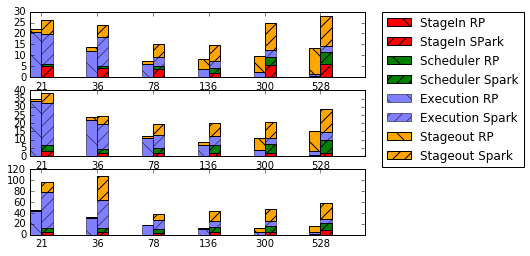

In [22]:
bar_l = np.arange(6)
width=0.20
a=plt.figure()
plt.title('Mean Task BreakDown')
plt.subplot(3, 1, 1)
#Stage IN
plt.bar(bar_l,[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        width,alpha=1.0,
        hatch='\\',
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_short_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn SPark',color='r')

# Scheduling
plt.bar(bar_l,[rp_haus_21_32_short['SchedulerDelay'].mean(),\
               rp_haus_36_24_short['SchedulerDelay'].mean(),\
               rp_haus_78_16_short['SchedulerDelay'].mean(),\
               rp_haus_136_12_short['SchedulerDelay'].mean(),\
               rp_haus_300_8_short['SchedulerDelay'].mean(),\
               rp_haus_528_6_short['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        hatch='\\',label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_short_ca,
        width,alpha=1.0,bottom=spco_stagein_short_ca,
        hatch='//',label='Scheduler Spark',color='g')

# Executing
plt.bar(bar_l,[rp_haus_21_32_short['Execution'].mean(),\
               rp_haus_36_24_short['Execution'].mean(),\
               rp_haus_78_16_short['Execution'].mean(),\
               rp_haus_136_12_short['Execution'].mean(),\
               rp_haus_300_8_short['Execution'].mean(),\
               rp_haus_528_6_short['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_short['SchedulerDelay'].mean()+rp_haus_21_32_short['StageInDelay'].mean(),\
                rp_haus_36_24_short['SchedulerDelay'].mean()+rp_haus_36_24_short['StageInDelay'].mean(),\
                rp_haus_78_16_short['SchedulerDelay'].mean()+rp_haus_78_16_short['StageInDelay'].mean(),\
                rp_haus_136_12_short['SchedulerDelay'].mean()+rp_haus_136_12_short['StageInDelay'].mean(),\
                rp_haus_300_8_short['SchedulerDelay'].mean()+rp_haus_300_8_short['StageInDelay'].mean(),\
                rp_haus_528_6_short['SchedulerDelay'].mean()+rp_haus_528_6_short['StageInDelay'].mean()],
        hatch='\\',
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_short_ca,
        width,alpha=0.5,
        bottom=spco_stagein_short_ca+spco_schedulerdelay_short_ca,
        hatch='//',
        label='Execution Spark')

# Stage out and Finalization
plt.bar(bar_l,[rp_haus_21_32_short['StageOut'].mean(),\
               rp_haus_36_24_short['StageOut'].mean(),\
               rp_haus_78_16_short['StageOut'].mean(),\
               rp_haus_136_12_short['StageOut'].mean(),\
               rp_haus_300_8_short['StageOut'].mean(),\
               rp_haus_528_6_short['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_short['Execution'].mean()+rp_haus_21_32_short['SchedulerDelay'].mean()+rp_haus_21_32_short['StageInDelay'].mean(),\
                rp_haus_36_24_short['Execution'].mean()+rp_haus_36_24_short['SchedulerDelay'].mean()+rp_haus_36_24_short['StageInDelay'].mean(),\
                rp_haus_78_16_short['Execution'].mean()+rp_haus_78_16_short['SchedulerDelay'].mean()+rp_haus_78_16_short['StageInDelay'].mean(),\
                rp_haus_136_12_short['Execution'].mean()+rp_haus_136_12_short['SchedulerDelay'].mean()+rp_haus_136_12_short['StageInDelay'].mean(),\
                rp_haus_300_8_short['Execution'].mean()+rp_haus_300_8_short['SchedulerDelay'].mean()+rp_haus_300_8_short['StageInDelay'].mean(),\
                rp_haus_528_6_short['Execution'].mean()+rp_haus_528_6_short['SchedulerDelay'].mean()+rp_haus_528_6_short['StageInDelay'].mean()],
        hatch='\\',label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_short_ca,
        width,alpha=1.0,
        bottom=spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca,
        hatch='//',label='Stageout Spark',color='orange')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))


plt.subplot(3, 1, 2)
# Stage In

plt.bar(bar_l,[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        width,alpha=1.0,
        hatch='\\',
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_med_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

# Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_med['SchedulerDelay'].mean(),\
               rp_haus_36_24_med['SchedulerDelay'].mean(),\
               rp_haus_78_16_med['SchedulerDelay'].mean(),\
               rp_haus_136_12_med['SchedulerDelay'].mean(),\
               rp_haus_300_8_med['SchedulerDelay'].mean(),\
               rp_haus_528_6_med['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        hatch='\\',label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_med_ca,
        width,alpha=1.0,bottom=spco_stagein_med_ca,
        hatch='//',label='Scheduler',color='g')

# Execution 
plt.bar(bar_l,[rp_haus_21_32_med['Execution'].mean(),\
               rp_haus_36_24_med['Execution'].mean(),\
               rp_haus_78_16_med['Execution'].mean(),\
               rp_haus_136_12_med['Execution'].mean(),\
               rp_haus_300_8_med['Execution'].mean(),\
               rp_haus_528_6_med['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_med['SchedulerDelay'].mean()+rp_haus_21_32_med['StageInDelay'].mean(),\
                rp_haus_36_24_med['SchedulerDelay'].mean()+rp_haus_36_24_med['StageInDelay'].mean(),\
                rp_haus_78_16_med['SchedulerDelay'].mean()+rp_haus_78_16_med['StageInDelay'].mean(),\
                rp_haus_136_12_med['SchedulerDelay'].mean()+rp_haus_136_12_med['StageInDelay'].mean(),\
                rp_haus_300_8_med['SchedulerDelay'].mean()+rp_haus_300_8_med['StageInDelay'].mean(),\
                rp_haus_528_6_med['SchedulerDelay'].mean()+rp_haus_528_6_med['StageInDelay'].mean()],
        hatch='\\',
        label='Execution')

plt.bar(bar_l+width,spco_execution_med_ca,
        width,alpha=0.5,
        bottom=spco_stagein_med_ca+spco_schedulerdelay_med_ca,
        hatch='//',
        label='Execution')

# Stage Out
plt.bar(bar_l,[rp_haus_21_32_med['StageOut'].mean(),\
               rp_haus_36_24_med['StageOut'].mean(),\
               rp_haus_78_16_med['StageOut'].mean(),\
               rp_haus_136_12_med['StageOut'].mean(),\
               rp_haus_300_8_med['StageOut'].mean(),\
               rp_haus_528_6_med['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_med['Execution'].mean()+rp_haus_21_32_med['SchedulerDelay'].mean()+rp_haus_21_32_med['StageInDelay'].mean(),\
                rp_haus_36_24_med['Execution'].mean()+rp_haus_36_24_med['SchedulerDelay'].mean()+rp_haus_36_24_med['StageInDelay'].mean(),\
                rp_haus_78_16_med['Execution'].mean()+rp_haus_78_16_med['SchedulerDelay'].mean()+rp_haus_78_16_med['StageInDelay'].mean(),\
                rp_haus_136_12_med['Execution'].mean()+rp_haus_136_12_med['SchedulerDelay'].mean()+rp_haus_136_12_med['StageInDelay'].mean(),\
                rp_haus_300_8_med['Execution'].mean()+rp_haus_300_8_med['SchedulerDelay'].mean()+rp_haus_300_8_med['StageInDelay'].mean(),\
                rp_haus_528_6_med['Execution'].mean()+rp_haus_528_6_med['SchedulerDelay'].mean()+rp_haus_528_6_med['StageInDelay'].mean()],
        hatch='\\',label='Stageout',color='orange')

plt.bar(bar_l+width,spco_stageout_med_ca,
        width,alpha=1.0,
        bottom=spco_stagein_med_ca+spco_schedulerdelay_med_ca+spco_execution_med_ca,
        hatch='//',label='Stageout',color='orange')

plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.subplot(3, 1, 3)

# Stage In
plt.bar(bar_l,[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        width,alpha=1.0,
        hatch='\\',
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_long_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

#Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_long['SchedulerDelay'].mean(),\
               rp_haus_36_24_long['SchedulerDelay'].mean(),\
               rp_haus_78_16_long['SchedulerDelay'].mean(),\
               rp_haus_136_12_long['SchedulerDelay'].mean(),\
               rp_haus_300_8_long['SchedulerDelay'].mean(),\
               rp_haus_528_6_long['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        hatch='\\',label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_long_ca,
        width,alpha=1.0,bottom=spco_stagein_long_ca,
        hatch='//',label='Scheduler',color='g')

# Execution
plt.bar(bar_l,[rp_haus_21_32_long['Execution'].mean(),\
               rp_haus_36_24_long['Execution'].mean(),\
               rp_haus_78_16_long['Execution'].mean(),\
               rp_haus_136_12_long['Execution'].mean(),\
               rp_haus_300_8_long['Execution'].mean(),\
               rp_haus_528_6_long['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_long['SchedulerDelay'].mean()+rp_haus_21_32_long['StageInDelay'].mean(),\
                rp_haus_36_24_long['SchedulerDelay'].mean()+rp_haus_36_24_long['StageInDelay'].mean(),\
                rp_haus_78_16_long['SchedulerDelay'].mean()+rp_haus_78_16_long['StageInDelay'].mean(),\
                rp_haus_136_12_long['SchedulerDelay'].mean()+rp_haus_136_12_long['StageInDelay'].mean(),\
                rp_haus_300_8_long['SchedulerDelay'].mean()+rp_haus_300_8_long['StageInDelay'].mean(),\
                rp_haus_528_6_long['SchedulerDelay'].mean()+rp_haus_528_6_long['StageInDelay'].mean()],
        hatch='\\',
        label='Execution')

plt.bar(bar_l+width,spco_execution_long_ca,
        width,alpha=0.5,
        bottom=spco_stagein_long_ca+spco_schedulerdelay_long_ca,
        hatch='//',
        label='Execution')

# Stage Out
plt.bar(bar_l,[rp_haus_21_32_long['StageOut'].mean(),\
               rp_haus_36_24_long['StageOut'].mean(),\
               rp_haus_78_16_long['StageOut'].mean(),\
               rp_haus_136_12_long['StageOut'].mean(),\
               rp_haus_300_8_long['StageOut'].mean(),\
               rp_haus_528_6_long['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_long['Execution'].mean()+rp_haus_21_32_long['SchedulerDelay'].mean()+rp_haus_21_32_long['StageInDelay'].mean(),\
                rp_haus_36_24_long['Execution'].mean()+rp_haus_36_24_long['SchedulerDelay'].mean()+rp_haus_36_24_long['StageInDelay'].mean(),\
                rp_haus_78_16_long['Execution'].mean()+rp_haus_78_16_long['SchedulerDelay'].mean()+rp_haus_78_16_long['StageInDelay'].mean(),\
                rp_haus_136_12_long['Execution'].mean()+rp_haus_136_12_long['SchedulerDelay'].mean()+rp_haus_136_12_long['StageInDelay'].mean(),\
                rp_haus_300_8_long['Execution'].mean()+rp_haus_300_8_long['SchedulerDelay'].mean()+rp_haus_300_8_long['StageInDelay'].mean(),\
                rp_haus_528_6_long['Execution'].mean()+rp_haus_528_6_long['SchedulerDelay'].mean()+rp_haus_528_6_long['StageInDelay'].mean()],
        hatch='\\',label='Stageout',color='orange')

plt.bar(bar_l+width,spco_stageout_long_ca,
        width,alpha=1.0,
        bottom=spco_stagein_long_ca+spco_schedulerdelay_long_ca+spco_execution_long_ca,
        hatch='//',label='Stageout ',color='orange')
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('MeanTaskBreakDown.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [23]:
spco_stagein_med_ca+spco_schedulerdelay_med_ca

array([[ 6.44373016],
       [ 4.5057037 ],
       [ 5.18089744],
       [ 6.61226225],
       [ 7.26247778],
       [ 9.94344318]])

   Atom  Cores Length       Mean       Std
0    CA     21  Short  29.901927  0.269167
1    CA     36  Short  21.579858  0.089385
2    CA     78  Short  16.711228  0.506717
3    CA    136  Short  18.236509  0.398640
4    CA    300  Short  25.308750  0.167655
5    CA    528  Short  36.360694  0.514873
6    CA     21    Med  50.535447  0.557145
7    CA     36    Med  35.146621  0.524774
8    CA     78    Med  22.680920  0.374103
9    CA    136    Med  18.912510  0.337302
10   CA    300    Med  26.304018  0.126124
11   CA    528    Med  38.256624  1.356314
12   CA     21   Long  58.019542  0.242621
13   CA     36   Long  53.936318  0.380839
14   CA     78   Long  33.961776  0.094742
15   CA    136   Long  26.557498  0.599745
16   CA    300   Long  26.708923  0.336970
17   CA    528   Long  38.494316  0.192622


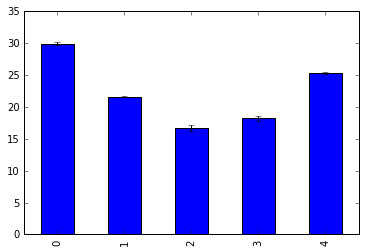

In [24]:
print rp_haus_overall
rp_haus_overall['Mean'][0:5].plot.bar(yerr=rp_haus_overall['Std'])

In [25]:
rp_haus_528_6_short_ca_3

,CU,New,StageIn,Allocate,Exec,StageOut,Done
0,unit.000000,-39.339862,7.676290,7.690855,7.923435,9.527824,14.104130
1,unit.000001,-39.339651,8.156314,8.190635,8.290122,9.640183,15.044066
2,unit.000002,-39.339506,8.226976,8.251492,8.352324,9.748369,16.353624
3,unit.000003,-39.339365,8.261008,8.297187,8.383212,9.641667,15.225866
4,unit.000004,-39.339224,8.323602,8.341906,8.456768,9.649424,15.277334
5,unit.000005,-39.339071,8.387914,8.407623,8.500554,9.859321,16.452491
6,unit.000006,-39.338929,8.454781,8.483857,8.530183,9.962031,16.502013
7,unit.000007,-39.338790,8.609153,8.634531,8.672768,10.182554,16.750005
8,unit.000008,-39.338630,8.956998,8.973001,9.216882,10.510120,18.122974
9,unit.000009,-39.338441,9.178094,9.195440,9.475194,10.618656,18.420306


# Analysis and Modeling

The execution model can be easily broken to different parts.  First part of the model is data StageIn. In case of RADICAL-Pilot StageIn is rather easy to undeerstand. In case of Spark, I consider as StageIn the part of the code that is written before partitioning the data. Second part is the time need to schedule a task. Third is the actual execution of the task, which can be broken further more to read, exec and write. Finally, the last part of the model is the time necessary to stage out the data. In case of RADICAL-Pilot it is easy to understand. In Spark, I consider as the time needed from the time that all tasks have returned their data until the end of the script.

Essentially, the model will look like:

$$T=\alpha(N_I S_I)+\beta\frac{k(k+1)}{2}+\gamma Y+\delta(N_O S_O)$$

$Y$ is the tme of the execution of the task. That is dependent to the number of trajectories being processed and the number of points in each trajectory. Let $T_N$ be the number of trajectories per task and $T_S$ the size of each trajectory, i.e. the number of points.Thus, the above execution time can be

$$Y = (T_N T_S)r+{T_N}^2 \Big(m {T_S}^2\Big)+{T_N}^2 w$$
